## Introduction  
In this lab, we would like to make an XGBoost model to study over the ecommerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data from the local machine onto a Pandas Dataframe.

## Objectives
- Apply XGBoost to an example

## Instruction

- Accept the kaggle policy and download the data from here https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data
- For the first model building, we'll only use the 2019-Nov csv data (which is still around ~2gb)

In [2]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as dates
from datetime import datetime
x = 4

%matplotlib inline

In [4]:
path = 'C:\\Users\\airyan\\Documents\\'

In [5]:
df = pd.read_csv(path+ "2019-Nov.csv")

Let's do some exploratory analysis on the data!

In [6]:
# take a quick look of the data
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [8]:
df.shape

(67501979, 9)

In [9]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site?

In [10]:
visitor = df['user_id'].nunique()
print ("visitors: {}".format(visitor))

visitors: 3696117


# Visitors Daily Trend
Does traffic flunctuate by date? Try using the `event_time` and `user_id` to see traffic, and draw out the plots for visualization. 

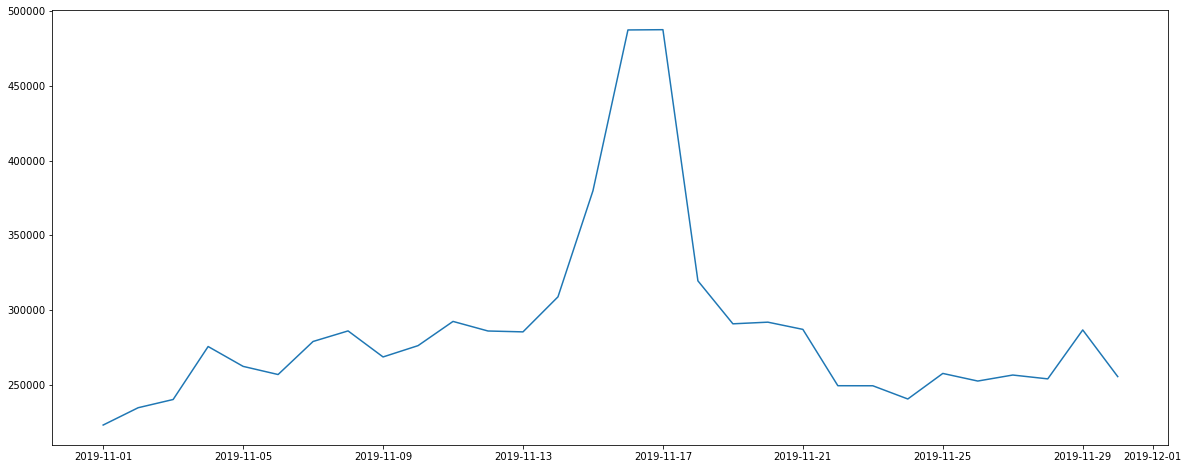

In [11]:
    d = df.loc[:,['event_time','user_id']]
    d['event_time'] = d['event_time'].apply(lambda s: str(s)[0:10])
    visitor_by_date = d.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
    x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
    y = visitor_by_date['count']
    plt.rcParams['figure.figsize'] = (20,8)

    plt.plot(x,y)
    plt.show()

### By Category and Product
Which category customers interact the most? What brand the view to most? You can limit the number of category number to 30 to draw out the plots.

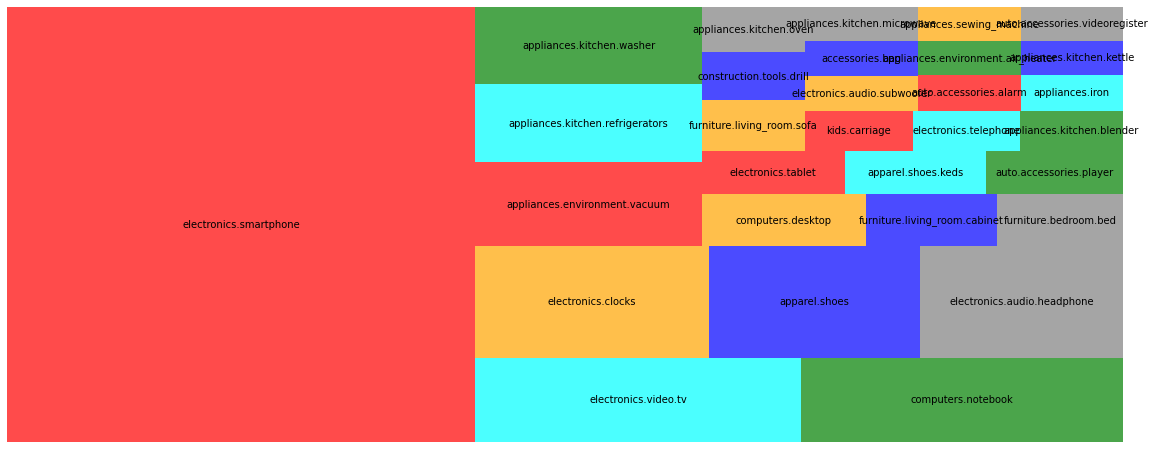

In [12]:
max_category_num = 30
top_category = df.loc[:,'category_code'].value_counts()[:max_category_num].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

## event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

In [13]:
# your code
max_category_num = 30
cart_purchase_users_all_activity =  df.loc[df['event_type'] == 'purchase', 'category_code'].value_counts()[:max_category_num].sort_values(ascending=False)
print(cart_purchase_users_all_activity)



electronics.smartphone                 382647
electronics.audio.headphone             40834
electronics.video.tv                    30274
electronics.clocks                      23237
appliances.kitchen.washer               19772
computers.notebook                      18433
appliances.environment.vacuum           18193
appliances.kitchen.refrigerators        13042
apparel.shoes                           10140
electronics.tablet                       6138
appliances.kitchen.microwave             5146
appliances.iron                          4650
electronics.telephone                    4338
appliances.kitchen.blender               4042
auto.accessories.player                  3793
computers.desktop                        3781
appliances.kitchen.oven                  3734
appliances.environment.air_heater        3583
appliances.kitchen.kettle                3559
appliances.environment.water_heater      3382
auto.accessories.alarm                   3258
construction.tools.drill          

## What brands the customers buy?
Try grouping by brand and sort values by the brand name.

In [15]:
# Group by brand and count the number of purchases for each brand
brand_purchase_counts = df.loc[df['event_type'] == 'purchase'].groupby('brand')['event_type'].count()

# Sort the counts by brand name
sorted_brand_purchase_counts = brand_purchase_counts.sort_values(ascending=False)

# Print the sorted counts
print(sorted_brand_purchase_counts)

brand
samsung       200027
apple         166064
xiaomi         68292
huawei         23703
cordiant       16983
               ...  
joker              1
joieanglia         1
jetem              1
jasmine            1
la-di-da           1
Name: event_type, Length: 2486, dtype: int64


# Modeling: predict at time of addition to shopping cart if user will purchase a given product or not
### Feature engineering

The goal of the modeling is to predict if the user will purchase a product or not when they add the product on the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data which customers have "put" the product in the cart.

Create these new features into the training data set:
- `category_level1`: category
- `category_level2`: sub-category
- `weekday`: weekday of the event
- `activity_count`: number of activity in that session
- `is_purchased`: whether the put in cart item is purchased, this will be our categorical output.

Make sure to de-dup any record.

In [16]:
df[['category_level1', 'category_level2']] = df['category_code'].str.split('.', expand=True)

KeyboardInterrupt: 

**Prepare a dataframe for counting activity in the session**

In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

In [17]:
del d # free memory

In [18]:
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

NameError: name 'df_targets' is not defined

## Save new data structure for modeling

In [ ]:
df_targets.to_csv('training_data.csv')

In [ ]:
df_targets.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [ ]:
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0]

In [ ]:
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0]

In [ ]:
n_samples = 500000
is_purchase_downsampled = resample(is_purcahase_set,
                                replace = False, 
                                n_samples = n_samples,
                                random_state = 27)
not_purcahase_set_downsampled = resample(not_purcahase_set,
                                replace = False,
                                n_samples = n_samples,
                                random_state = 27)

In [ ]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled['is_purchased'].value_counts()

In [ ]:
features = downsampled.loc[:,['brand', 'price', 'event_weekday', 'category_code_level1', 'category_code_level2', 'activity_count']]

## Encode categorical variables

In [ ]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
features.loc[:,'category_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_level1'].copy())
features.loc[:,'category_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_level2'].copy())

is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()

In [ ]:
print(list(features.columns))

## Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

## Train the model
Choose learning rate of 0.1 on XGBClassifier.

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

## Feature importance
Show feature importance using plot_importance

In [ ]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()